# Complex Cross Correlation Performance

The purpose of this notebook is to investigate the sensitivity of complex cross correlation for speckle tracking to various parameters. Note, all experiment assume a zero phase gradient across the patches. In reality, phase gradients are present and will reduce performance. For much of the interior of the ice sheet where gradients are small, however, complex correlation works quite well. For simplicity, all experiments assume small offsets (< 1 pixel). As a result, circular convolution is used. In actuality, a zero padded buffer may be needed to expand the search radius, but the peformance with respect to the parameters examined here should be similar. For further simplicity, all matches will be performed with a square windows (though the code can support rectangular windows.)

In [17]:
import psutil
import os

## Supporting Code

The results in this notebook make use of a supporting set of python functions that can be found at: https://github.com/fastice/nisarfunc. To install, go to a directory in your Python path (if you haven't set a Python path you will need to; google "setting python path".) The necesary functions are then imported as:

In [18]:
import nisarfunc as nf

Other packages that are used are imported as (you may need to install if they don't load):

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note these experiments use an fft to oversample the correlation peak to obtain subpixel results. The code is written so that a different peak interpolator can be used. Specifically, the cross correlation is defined as `nccPatches(...subPix=osSubPix, subPixArgs=(10, 4), subPixKwArgs={})` so that the oversampling is accomplished as `subPix(*subPixArgs, **subPixKwArgs)`.

Since the simulations are can be time consuming if a lot of realizations are used, the code can be multi-threaded to run `nJobs` as:

    speckleJobs = nf.speckleJobs(myFunction) # Setup an object to multi-thread myFunction 
    speckleJobs.runNInstances(nJobs, arg1, arg2,..,keyw1=....) 
    results = speckleJobs.results # list with nJob elements, each containing a thread output 
    speckleJobs.reset() # Reset to run a fresh set (otherwise results will be accumulated)

### Number of Instances

More samples will improve the quality of the estimates, but take longer to run. The variable `nInstances` is used by all simulations. It can be set to a low number for debugging and notebook demonstration and to a larger number to generate higher fidelity results.

In [20]:
nInstances = 1000

## Window Size

The search window size for correlation matching is an important parameter in matching. In generally, larger windows should yield cleaner matches, but with some caveats. As windows get larger, the potential for phase gradients to reduce correlation increases. Furthermore, larger windows yield lower resolution. In addition, there is always some quantization error depending on how finely the peak can be resolve, so at some point that can set a noise floor so that larger windows produce little added benefit. In such cases, its likely better to average results from several smaller windows, which reduce quantization noise. 

The following function will simulate white noise patches with a specified level of correlation $\rho$ and subpixel row and column offsets ($\delta_r$ and $\delta_c$). The cross correlation algorithm will then return estimates of these offsets ($\hat{\delta_r}$ and $\hat{\delta_c}$). The routine will then return the errors ($e_r = \hat{\delta_r} - \delta_r$ and $e_c = \hat{\delta_c} - \delta_c$).

In [21]:
def cmpxWindowSize(ws, rho, osPeak, osBox, overSample=False, subPix=nf.osSubPix):
    # randomize both the osFactor and offset to vary offsets
    osFactor = random.randint(6,8)  # Oversample factor used to generate shifts, so shifts in increments of 1/osFactor
    deltaR, deltaC = random.randint(1, osFactor-1), random.randint(1, osFactor-1)  # Randomly vary offsets to avoid an single offset bias
    patchS, patchR = nf.correlatedShiftedPatches(ws, ws, deltaR, deltaC, rho, overSample=osFactor, sigma=1.0)  # sim data
    deltaRHat, deltaCHat, cmax, _, _ = nf.nccPatches(patchS, patchR, subPixArgs=(osPeak, osBox),overSampleCorr=overSample,
                                                     ampMatch=False, subPix=subPix)
    return deltaRHat - deltaR/osFactor, deltaCHat - deltaC/osFactor

def matchStats(results):
    ''' Compute stats from results'''
    if np.sum(np.isfinite(results)) != 0:  # Check that not all failed
        sigma= np.nanstd(results)
        percentSuccess = np.sum(np.isfinite(results)) / (results.shape[0] * results.shape[1]) * 100.
        return sigma, percentSuccess
    return np.nan, 0

The results in many of the following examples can be plotted as:

In [22]:
def plotErrorAndSuccessRate(resultsSigma, resultsPercent, rhos, windows, title='', \
                            xlabel='Window Size (pixels)', ylabels=['Error (pixels)', '% success']):
    fig, myAxes = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    for rho in rhos:
        myAxes[0].plot(windows, resultsSigma[rho],'*-', label=rho)
        myAxes[1].plot(windows, resultsPercent[rho],'*-', label=rho)
    for myAxis, xlab, ylab in zip(myAxes, [xlabel] * 2, ylabels):
        myAxis.legend()
        myAxis.set_xlabel(xlab, fontSize=14)
        myAxis.set_ylabel(ylab, fontSize=14)

To simulate window size varation, the following code can be used:

In [23]:
def windowSim(windows, rhos, overSample):
    speckleJobs = nf.speckleJobs(cmpxWindowSize)
    resultsSigma = {rho : [] for rho in rhos}
    resultsPercent = {rho : [] for rho in rhos}
    osPeak, osBox = 40, 4
    for rho in rhos:
        for window in windows:
            print(f'\rrho={rhos[rho]} window {window} ', end='')
            speckleJobs.runNInstances(nInstances, window, rhos[rho], osPeak, osBox, overSample=overSample)
            sigma, percentSuccess = matchStats(np.array(speckleJobs.results))
            resultsSigma[rho].append(sigma)
            resultsPercent[rho].append(percentSuccess)
            speckleJobs.reset()
    
    plotErrorAndSuccessRate(resultsSigma, resultsPercent, rhos, windows,\
                            title=f'Peformance vs Window Size for osPeak={osPeak}, $\pm$osBox={osBox}, '
                            f'overSample={overSample}, nSamples={nInstances}')

### Simulation Parameters

The following parameters are used for the next two simulations:

In [24]:
windows = [24, 48, 64, 72, 96]
rhos = {'low': 0.2, 'medium' : 0.5, 'high' : 0.8}

### No Prior Oversampling

Using this function, the following code will simulate errors for several window sizes for low (.2) medium (0.5) and high (0.8) correlation.

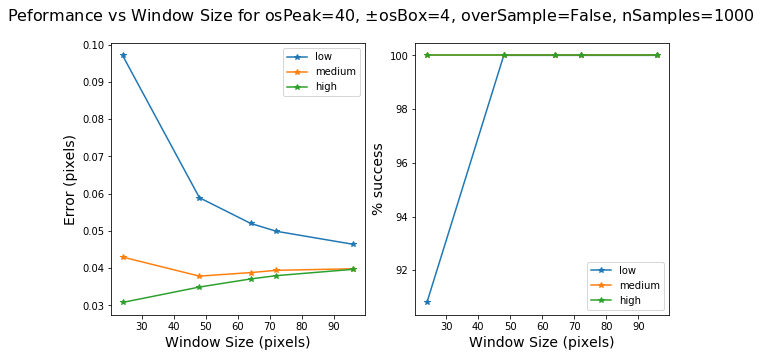

In [25]:
overSample = False
windowSim(windows, rhos, overSample)

**Figure 1. Matching performance as a function of window size with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to complex correlation value of $\rho=0.2$ (low), $\rho=0.5$ (medium), and $\rho=0.8$ (high)**

### Oversampling

Oversampling can be important for detected images, but should make little difference for complex matching, except for its effect on the peak oversampling. In this example, the complex data are oversampled, but the p

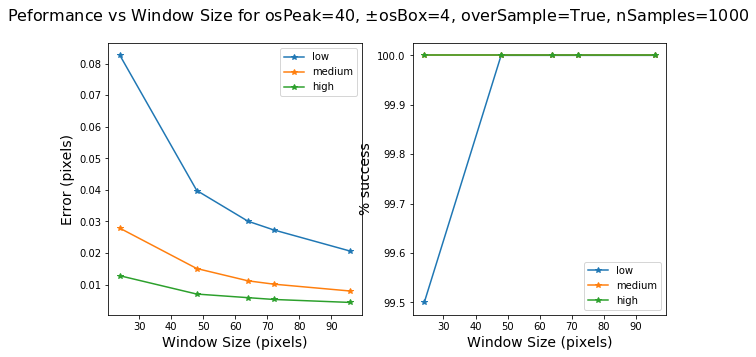

In [26]:
overSample = True
windowSim(windows, rhos, overSample)

**Figure 2. Matching performance as a function of window size with 2xpatch overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to complex correlation value of $\rho=0.2$ (low), $\rho=0.5$ (medium), and $\rho=0.8$ (high)**

## Peak Oversample Factor

There are multiple ways to oversample the peak the range from oversamping to fitting some functional form (polynomial or Gaussian). A simple and straight forward approach is to extract the region with $\pm$`osBox` around the correlation peak, oversample that by a factor `osPeak`, and then find the subpixel maximimum from this result. Since the peak cannot be oversampled with infinite precision, there should be an upper limits on `osBox` and `osPeak` after which the point of diminishing returns is reached. The code evaluates the accuracy (or at least precission) of the oversampling operations over a range of `osBox` and `osPeak` values.

In [27]:
def peakOverSample(window, rho, overSample, subPix=nf.osSubPix, osPeaks=[4, 10, 20, 40, 80], osBoxes=[2, 4, 8, 12]):
    if osBoxes[-1] >= (window/2):
        print(f'osBox={osBoxes[-1]} should be less than half window size {window}- returning')
        return
    speckleJobs = nf.speckleJobs(cmpxWindowSize) 
    resultsSigma = {str(osPeak) : [] for osPeak in osPeaks}
    resultsPercent = {str(osPeak) : [] for osPeak in osPeaks}
    #
    for osPeak in osPeaks:
        for osBox in osBoxes:
            print(f'\rosBox={osBox} osPeak {osPeak} ', end='')
            speckleJobs.runNInstances(nInstances, window, rho, osPeak, osBox, overSample=overSample,subPix=subPix)
            sigma, percentSuccess = matchStats(np.array(speckleJobs.results))
            resultsSigma[str(osPeak)].append(sigma)
            resultsPercent[str(osPeak)].append(percentSuccess)
            speckleJobs.reset()
    #
    plotErrorAndSuccessRate(resultsSigma, resultsPercent, [str(osPeak) for osPeak in osPeaks], osBoxes,
                            xlabel='$\pm$osBox (pixels)',
                            title=f'Peformance vs osBox for rho={rho}, windowSize={window}, '
                            f'overSample={overSample}, nSamples={nInstances} with subPix={subPix.__name__}')

### Simulation Parameters

The following parameters are used for the nex four simulations:

In [28]:
window = 32
rho = 0.4

### Matching with non-Oversampled data

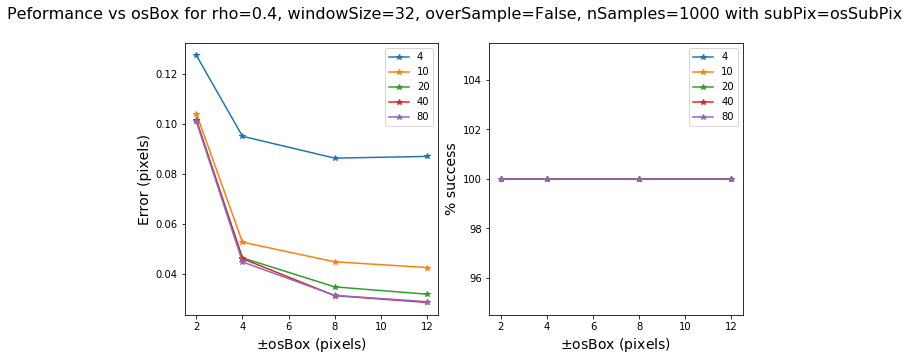

In [29]:
overSample = False
peakOverSample(window, rho, overSample)

**Figure 3. Matching performance as a function of oversampled area around the peak ($\pm$'osBox') with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

The results shown above indicate a value of `osBox=8` is near the point of diminishing returns with virtually no improvement for `osPeak > 40`, with reasonably acceptable results with `osPeak=20`. When the patch is initially oversampled (see Oversamplign above), however, the performance is batter than that shown here. Thus, the patch oversampling experiment can be combined with the peak oversampling for the code shown below. Note in the oversampler, 'osBox' is scaled by the 2x oversample factor, so it represents the same value in single pixel values. 

### Matching with 2x Oversampling

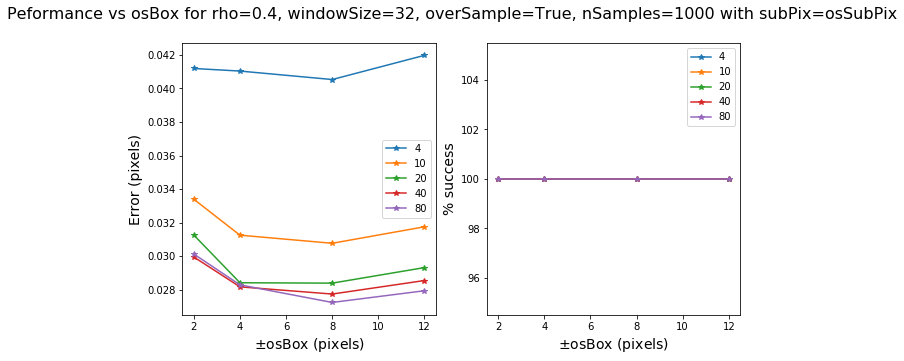

In [30]:
overSample = True
peakOverSample(window, rho, overSample)

**Figure 4. Matching performance as a function of oversampled area around the peak ($\pm$`osBox`) with 2x overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

The results above are consistent with first two experiments focused on window size. Notably, the sub-pixel accuracy seems greatly improved when the complex data are oversampled prior to matching. For complex matching, the oversampling can be accomplished using a NxN forward transform on each patch, the spectra can then be multiplied, and then the inverse transformed with a 2Nx2N transform after zero padding. In this case with `osPeak=20` and `osBox=4`, the fft width is 20x2x2x4=160 (one factor of 2 for $\pm$`osBox` and the other to acount for the 2x oversampling as described above.) By contrast, for no oversampling, `osPeak=20` and `osBox=8` yields quantization error about twice as large, for a peak oversampling fft of the same size (160=20x2x8). The 2x patch oversampling adds cost (substituting one 48x48 FFT for a 96x96 FFT), but that cost should be small relative to the larger FFT needed for oversampling. And a net computational savings can realized with `osPeak=10` and `osBox=2 or 4`. 

## Gaussian Fit to Peak

Rather than oversampling the peak to the high resolution, offsets can be determined by fitting a Gaussian peak to less finely oversampled data (e.g., as in autoRift). The two examples repeat the two peak oversampling experiments described above but substitution of `nf.osSubPixGaussian` for `ns.osSubPix`. 

### Gausian Fit with no Initial Oversampling

In this example, `overSample=False` so the 2x oversampling is turned off.

osBox=2 osPeak 4 .....

/home/ian/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


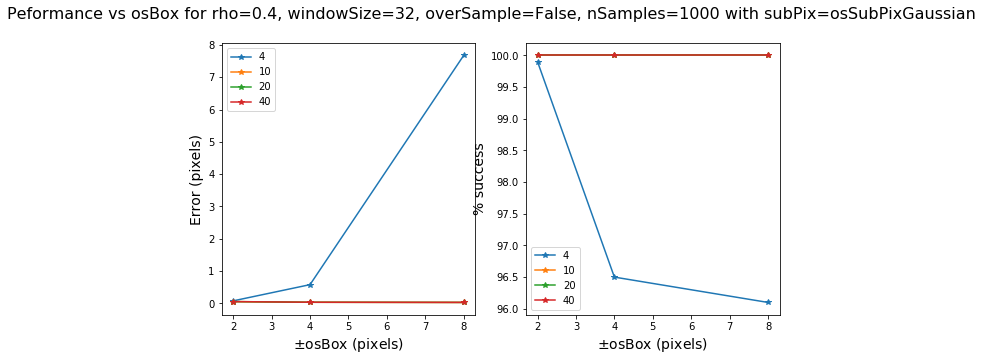

In [31]:
overSample = False
peakOverSample(window, rho, overSample, subPix=nf.osSubPixGaussian, osPeaks=[4, 10, 20, 40], osBoxes=[2, 4, 8])

**Figure 5. Matching performance for Gaussian-fit oversampling as a function of oversampled area around the peak ($\pm$`osBox`) with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

### Gausian Fit with 2x Oversampling

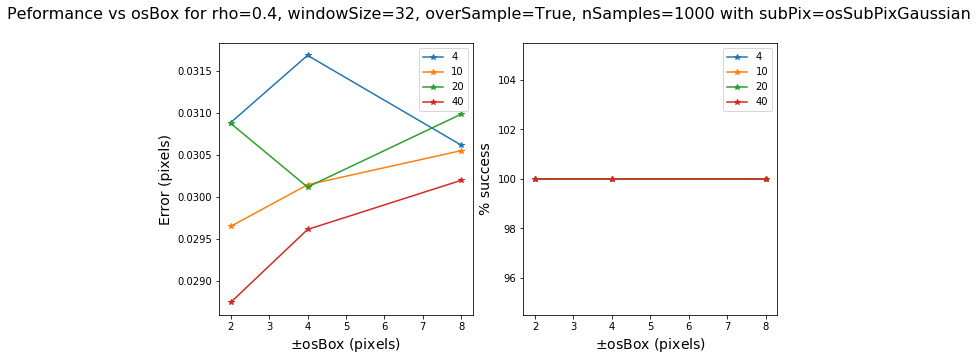

In [32]:
overSample = True
peakOverSample(window, rho, overSample, subPix=nf.osSubPixGaussian, osPeaks=[4, 10, 20, 40], osBoxes=[2, 4, 8])

**Figure 6. Matching performance for Gaussian-fit oversampling as a function of oversampled area around the peak ($\pm$`osBox`) with 2x overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`). Note, unlike the case for oversampling, the Gaussian fit uses data from only around the peak so expanding the box with can produce worse results.**

## Conclusions

The plots shown above reveal several import performance characteristics of speckle-tracking methods applied to complex data. Note many of the numbers given here apply to a specific value of $\rho$ (Figures 3-6). Absolute and relative performance will vary with different values of $\rho$, but qualitatively the observations below should still hold. Specifically:
* Complex correlation produces robust matches even at low levels of correlation (e.g., $\rho=0.2$). 
* For the two higher $\rho$ cases performance is relatively insenstive to window size. For $\rho=0.2$ there is a substantial difference in performance. But ignoring other factors, $n$ 24x24 pixel estimates could be performed more cheaply as single window of dimension 24$n$x24$n$ and the 1/n peformance improvement after averaging should more than make up the difference. If phase gradients had been present, the relative performance of smaller windows would improve further.
* Although not strictly required to remove aliasing effects, 2x oversampling of the data prior to cross correlation appears to improve performance signicantly (0.014 vs 0.02). Any increase in cost, can likely be offset by adusting the oversampling routine.
* There is a limit on how finely the correlation peak can be oversampled. The quantization level in terms of the error is given by:  $\Delta=\sqrt{12}\sigma$. In the examples above the best case $\sigma$ values are ~0.02 and ~0.014 for no- and 2x-oversampling, respectively. The corresponding quantization levels are $\Delta=0.069$ and $\Delta=0.048$ or about one tenth and one fifteenth of a pixel. Although these numbers are for moderate correlation, Figures 1 and 2 indicate peformance will not signifantly better even with $\rho=0.8$.
* Both peak-oversampling and peak-over sampling combined with Gaussian fitting yield similar matching performance. Which method offers the best computational efficiency needs more effort to determine.
* For no prior oversampling, a level of ~0.02 pixel error can be achieved with `osBox=8` and `osPeak=20` whereas these numbers reduce to `osBox=4` and `osPeak=10`, which reduces the FFT dimension a factor of 4.  This savings needs to be balanced against the TBD determined cost of the Gaussian fit. 
* For 2x oversampling, a near-optimal level of ~0.029 pixels can be achieved with `osBox=4` and `osPeak=20`. By contrast similar performance can be achieve with `osBox=2` and `osPeak=4` and a Gaussian fit, which reduces the FFT dimension by a factor of 10. It will depend on the window size, but 2x pre-oversampling with little peak oversampling combined with a Gaussian fit may yield the computational performance.